In [89]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting and graphics

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/streetcardata2024/TTC Streetcar Delay Data 2024.xlsx


In [90]:
!pip -q install xgboost optuna

In [91]:
import xgboost
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [92]:
import optuna

In [93]:
df = pd.read_excel('/kaggle/input/streetcardata2024/TTC Streetcar Delay Data 2024.xlsx')

if df.isna().any().any(): df.dropna(inplace=True)

In [94]:
df["DateTime"] = pd.to_datetime(
    df["Date"].dt.strftime("%Y-%m-%d") + " " + df["Time"]
)

df.drop(
    columns=["Date", "Time", "Bound", "Min Gap", "Vehicle"],
    axis=1,
    inplace=True
)

XGBoost cannot operate on raw datetime objects, so we need to split the information up.

In [95]:
df["Date"] = df["DateTime"].dt.day
df["Month"] = df["DateTime"].dt.month
df["Hour"] = df["DateTime"].dt.hour
df["Minute"] = df["DateTime"].dt.minute

In [96]:
valid_lines = [501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 301, 303, 304, 305, 306, 310, 311, 312]
df = df[df['Line'].isin(valid_lines)]

In [97]:
df.drop(columns=["Day"], axis=1, inplace=True)
df.drop(columns=["DateTime"], axis=1, inplace=True)
df["Line"] = df["Line"].astype(int)

We convert the locations into categorical values as well, using 

In [98]:
delaylocations = df["Location"].value_counts().index.tolist()
len(delaylocations)

1792

In [99]:
delayreasons = df["Incident"].value_counts().index.tolist()
len(delayreasons)

13

Since we have a lot of locations, we cannot use `pd.get_dummies` because this will create 2006 extra columns, which makes the dataset massive. This is bad for the model, because of the *Curse of Dimensionality* and the extremely slow training time. Instead, we need to use the **Label Encoder** from scikit-learn. The downside is that we are imposing arbitrary order on the locations, which the model might misinterpret.

In [100]:
labelencoder = LabelEncoder()
df["Location"] = labelencoder.fit_transform(df["Location"])

In [101]:
df["Incident"] = labelencoder.fit_transform(df["Incident"])

In [102]:
df.head()

,Line,Location,Incident,Min Delay,Date,Month,Hour,Minute
0,505,440,11,10,1,1,2,45
1,505,321,3,52,1,1,3,6
2,503,1080,11,0,1,1,3,21
3,505,524,11,37,1,1,3,53
5,501,1105,2,74,1,1,4,33


Split the dataset into train and test

In [103]:
X = df.drop(columns=["Min Delay"])
y = df["Min Delay"]

In [104]:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, random_state=505)

## XGBoost XGBRegressor Model

In [105]:
from sklearn.metrics import r2_score

In [106]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    reg_alpha =  trial.suggest_float('reg_alpha', 0.0, 35.0)
    reg_lambda = trial.suggest_float('reg_lambda', 0.0, 10.0)
    
    model = xgboost.XGBRegressor(
        n_estimators = n_estimators, # Weston Road North
        max_depth = max_depth,
        learning_rate = learning_rate,
        verbosity = 0,
        objective = 'reg:squarederror', # Use MSE
        booster = 'gbtree',
        subsample = 0.8,
        colsample_bytree = 0.8,
        eval_metric = 'rmse',
        reg_alpha = reg_alpha,
        reg_lambda = reg_lambda,
        random_state = 505
    )
    model.fit(X_train, y_train, eval_set = [(X_train, y_train)], verbose=False)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"R^2 Value: {r2:.6f}")
    return r2

In [107]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2025-02-11 21:23:56,193] A new study created in memory with name: no-name-eff56b51-aa28-4b1e-a90e-cd35897437ed
[I 2025-02-11 21:23:56,802] Trial 0 finished with value: 0.06630794683131924 and parameters: {'n_estimators': 316, 'max_depth': 7, 'learning_rate': 0.03483233507629391, 'reg_alpha': 16.720884103071047, 'reg_lambda': 5.146281907842489}. Best is trial 0 with value: 0.06630794683131924.


R^2 Value: 0.066308


[I 2025-02-11 21:23:58,084] Trial 1 finished with value: -0.21629559858706826 and parameters: {'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.21504869730758144, 'reg_alpha': 30.113303373115528, 'reg_lambda': 1.0782030252123487}. Best is trial 0 with value: 0.06630794683131924.


R^2 Value: -0.216296


[I 2025-02-11 21:23:58,943] Trial 2 finished with value: -0.03543836127553379 and parameters: {'n_estimators': 466, 'max_depth': 7, 'learning_rate': 0.06741241752821167, 'reg_alpha': 30.11357282631979, 'reg_lambda': 6.344558576076185}. Best is trial 0 with value: 0.06630794683131924.


R^2 Value: -0.035438


[I 2025-02-11 21:23:59,776] Trial 3 finished with value: 0.03138457876448553 and parameters: {'n_estimators': 369, 'max_depth': 8, 'learning_rate': 0.03307130785264411, 'reg_alpha': 2.2786618956869176, 'reg_lambda': 4.822114800214567}. Best is trial 0 with value: 0.06630794683131924.


R^2 Value: 0.031385


[I 2025-02-11 21:24:00,509] Trial 4 finished with value: 0.09228460555737295 and parameters: {'n_estimators': 460, 'max_depth': 6, 'learning_rate': 0.016879005718216607, 'reg_alpha': 16.710400375788446, 'reg_lambda': 5.70946153525683}. Best is trial 4 with value: 0.09228460555737295.
[I 2025-02-11 21:24:00,706] Trial 5 finished with value: 0.08745832950493193 and parameters: {'n_estimators': 161, 'max_depth': 4, 'learning_rate': 0.10438327475214665, 'reg_alpha': 9.683972282106835, 'reg_lambda': 6.566167952409724}. Best is trial 4 with value: 0.09228460555737295.


R^2 Value: 0.092285
R^2 Value: 0.087458


[I 2025-02-11 21:24:00,978] Trial 6 finished with value: 0.05138905576522923 and parameters: {'n_estimators': 112, 'max_depth': 8, 'learning_rate': 0.07199937488828871, 'reg_alpha': 4.910881126502058, 'reg_lambda': 7.934379613661488}. Best is trial 4 with value: 0.09228460555737295.


R^2 Value: 0.051389


[I 2025-02-11 21:24:01,545] Trial 7 finished with value: -0.03181070322844315 and parameters: {'n_estimators': 185, 'max_depth': 9, 'learning_rate': 0.042945992149774105, 'reg_alpha': 20.489168533644357, 'reg_lambda': 0.17644697816500687}. Best is trial 4 with value: 0.09228460555737295.


R^2 Value: -0.031811


[I 2025-02-11 21:24:02,051] Trial 8 finished with value: -0.15181235747453603 and parameters: {'n_estimators': 259, 'max_depth': 7, 'learning_rate': 0.26621868948590083, 'reg_alpha': 13.886419198397798, 'reg_lambda': 8.138726132506758}. Best is trial 4 with value: 0.09228460555737295.


R^2 Value: -0.151812


[I 2025-02-11 21:24:02,318] Trial 9 finished with value: 0.009510133450501335 and parameters: {'n_estimators': 191, 'max_depth': 5, 'learning_rate': 0.10635387290429689, 'reg_alpha': 14.65946785614961, 'reg_lambda': 2.63520396624355}. Best is trial 4 with value: 0.09228460555737295.


R^2 Value: 0.009510


In [108]:
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'n_estimators': 460, 'max_depth': 6, 'learning_rate': 0.016879005718216607, 'reg_alpha': 16.710400375788446, 'reg_lambda': 5.70946153525683}


In [109]:
best_model = xgboost.XGBRegressor(**best_params)

In [110]:
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.016879005718216607,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=460, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [111]:
y_test_pred = best_model.predict(X_test)
final_r2 = r2_score(y_test, y_test_pred)
print(f"Final Model R^2: {final_r2:.6f}")

Final Model R^2: 0.083807


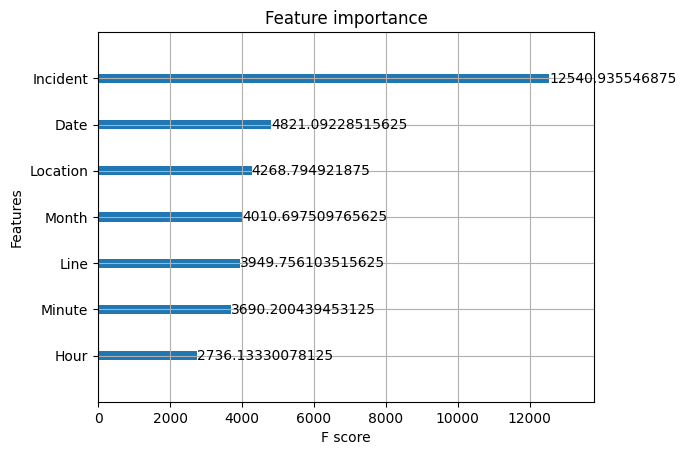

In [112]:
xgboost.plot_importance(best_model, importance_type="gain")  # Change to "weight" or "cover" as needed
plt.show()


Seems like Date, Minute and Month aren't really relevant. Hence we will drop those features from the dataset and try again.

In [113]:
df.drop(columns=["Date", "Minute", "Month", "Hour"], inplace=True)

In [114]:
X = df.drop(columns=["Min Delay"])
y = df["Min Delay"]

In [115]:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, random_state=505)

In [116]:
study2 = optuna.create_study(direction="maximize")
study2.optimize(objective, n_trials=10)

[I 2025-02-11 21:24:03,133] A new study created in memory with name: no-name-8889ed36-4f63-4d56-bb15-c86dc32cf9a4
[I 2025-02-11 21:24:03,310] Trial 0 finished with value: 0.0994808842172401 and parameters: {'n_estimators': 177, 'max_depth': 3, 'learning_rate': 0.10952717775988043, 'reg_alpha': 22.88147554380275, 'reg_lambda': 8.161273718912792}. Best is trial 0 with value: 0.0994808842172401.
[I 2025-02-11 21:24:03,428] Trial 1 finished with value: 0.06582674408106959 and parameters: {'n_estimators': 104, 'max_depth': 4, 'learning_rate': 0.20302045280195738, 'reg_alpha': 12.45162807523345, 'reg_lambda': 0.27496721600185015}. Best is trial 0 with value: 0.0994808842172401.


R^2 Value: 0.099481
R^2 Value: 0.065827


[I 2025-02-11 21:24:03,936] Trial 2 finished with value: 0.09628670473409162 and parameters: {'n_estimators': 285, 'max_depth': 9, 'learning_rate': 0.014290357166753967, 'reg_alpha': 31.695123680711106, 'reg_lambda': 9.753133376532716}. Best is trial 0 with value: 0.0994808842172401.


R^2 Value: 0.096287


[I 2025-02-11 21:24:04,215] Trial 3 finished with value: 0.10862935413990504 and parameters: {'n_estimators': 290, 'max_depth': 3, 'learning_rate': 0.0384766437982446, 'reg_alpha': 17.297215235658015, 'reg_lambda': 7.831276516330342}. Best is trial 3 with value: 0.10862935413990504.


R^2 Value: 0.108629


[I 2025-02-11 21:24:04,491] Trial 4 finished with value: 0.11531163746332129 and parameters: {'n_estimators': 186, 'max_depth': 7, 'learning_rate': 0.010145446559084578, 'reg_alpha': 29.95042924406816, 'reg_lambda': 9.268280544394894}. Best is trial 4 with value: 0.11531163746332129.


R^2 Value: 0.115312


[I 2025-02-11 21:24:05,109] Trial 5 finished with value: -0.05781423064961144 and parameters: {'n_estimators': 293, 'max_depth': 10, 'learning_rate': 0.0774991540020841, 'reg_alpha': 11.114023947239748, 'reg_lambda': 9.291512724092568}. Best is trial 4 with value: 0.11531163746332129.
[I 2025-02-11 21:24:05,286] Trial 6 finished with value: 0.014814060888451497 and parameters: {'n_estimators': 118, 'max_depth': 6, 'learning_rate': 0.2802753812143687, 'reg_alpha': 19.761293967277663, 'reg_lambda': 8.230193560756424}. Best is trial 4 with value: 0.11531163746332129.


R^2 Value: -0.057814
R^2 Value: 0.014814


[I 2025-02-11 21:24:05,449] Trial 7 finished with value: 0.11524544820440119 and parameters: {'n_estimators': 123, 'max_depth': 5, 'learning_rate': 0.02483464068050141, 'reg_alpha': 18.616676756781875, 'reg_lambda': 3.766564465804275}. Best is trial 4 with value: 0.11531163746332129.


R^2 Value: 0.115245


[I 2025-02-11 21:24:05,874] Trial 8 finished with value: 0.04126323666047582 and parameters: {'n_estimators': 291, 'max_depth': 7, 'learning_rate': 0.044475211718698796, 'reg_alpha': 33.756750094855555, 'reg_lambda': 5.615800663444672}. Best is trial 4 with value: 0.11531163746332129.


R^2 Value: 0.041263


[I 2025-02-11 21:24:06,169] Trial 9 finished with value: 0.11462020309766041 and parameters: {'n_estimators': 244, 'max_depth': 5, 'learning_rate': 0.016809262981683122, 'reg_alpha': 22.78672120809836, 'reg_lambda': 7.634922780553699}. Best is trial 4 with value: 0.11531163746332129.


R^2 Value: 0.114620


In [117]:
best_params2 = study2.best_params
print("Best Hyperparameters:", best_params2)
best_model2 = xgboost.XGBRegressor(**best_params2)
best_model2.fit(X_train, y_train)

Best Hyperparameters: {'n_estimators': 186, 'max_depth': 7, 'learning_rate': 0.010145446559084578, 'reg_alpha': 29.95042924406816, 'reg_lambda': 9.268280544394894}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.010145446559084578,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=186, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [118]:
y_test_pred2 = best_model2.predict(X_test)
final_r22 = r2_score(y_test, y_test_pred2)
print(f"Final Model R^2: {final_r22:.6f}")

Final Model R^2: 0.110962


Marginal. Improvement. Let's try using SHAP.